In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import heapq
from networkx.algorithms import edge_boundary
from scipy.sparse import dok_matrix


In [2]:
def compute_transition_matrix(graph):
    """Compute the transition probabilities for a random walk"""
    adjacency = nx.to_numpy_array(graph, dtype=float)  # Convert graph to adjacency matrix
    row_sums = adjacency.sum(axis=1, keepdims=True) # Row sums
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    return adjacency / row_sums # Normalize rows to get transition probabilities

def simulate_random_walk(graph, transition_matrix, steps=100000):
    """Simulate a long random walk to estimate node visit frequencies"""
    nodes = list(graph.nodes)
    node_to_index = {node: idx for idx, node in enumerate(nodes)}  # Map nodes to their indices
    visit_counts = defaultdict(int) # Define a dictionary to store visit counts
    
    #i have to include the fact that the graph could be disconnected
    # Start at a random node
    for i in range(100):
        current_node = np.random.choice(nodes)    
        for _ in range(steps):
            visit_counts[current_node] += 1
            neighbors = list(graph.neighbors(current_node)) # Get neighbors of current node
            if neighbors:
                current_index = node_to_index[current_node]  # Find index of current node
                neighbor_indices = [node_to_index[n] for n in neighbors]  # Find indices of neighbors
                probabilities = np.array([transition_matrix[current_index, idx] for idx in neighbor_indices]) # Get transition probabilities
                probabilities /= probabilities.sum()  # Normalize probabilities
                current_node = np.random.choice(neighbors, p=probabilities) # Move to a neighbor based on probabilities
        
    # Normalize visit counts to get probabilities
    visit_counts = {node: count for node, count in visit_counts.items() if node in graph.nodes}  # Filter out nodes not in graph
    total_visits = sum(visit_counts.values()) # Compute total number of visits for each node
    return {node: visit_counts[node] / total_visits for node in graph.nodes} # Normalize visit counts to get probabilities

In [3]:

def compute_map_equation(graph, transition_matrix, visit_probs, partition):
    """Compute the map equation for the current partitioning"""
    module_probs = defaultdict(float) # Initialize module probabilities
    teleport_term = defaultdict(float) # Initialize teleport probabilities
    non_teleport = defaultdict(float) # Initialize exit probabilities

    tau = 0.01  # Teleport probability
    node_to_index = {node: idx for idx, node in enumerate(graph.nodes)}
    #n = len(set(partition.values()))  # Count the number of unique partitions
    q = defaultdict(float)  # Initialize exit probabilities

    for node, module in partition.items():
        module_probs[module] += visit_probs[node] # Compute module probabilities as sum of visit probabilities 
        #ni = sum(1 for m in graph.nodes if partition[m] == module)  # Count nodes in the partition
        #teleport_term[module] += tau * (n - ni) / (n-1) * visit_probs[node] 
        teleport_term[module] += 0
        for neighbor in graph.neighbors(node): 
            if partition[neighbor] != module: # If neighbor is in a different module
                node_idx = node_to_index[node] # Get index of current node
                neighbor_idx = node_to_index[neighbor]  # Get index of neighbor
                non_teleport[module] +=  (1 - tau) * visit_probs[node] * transition_matrix[node_idx, neighbor_idx]  # Compute exit probabilities

    for module in module_probs.keys():
        q[module] = teleport_term[module] + non_teleport[module]  # Compute exit probabilities

    
    def safe_log2(x):
        return np.log2(x) if x > 0 else 0

    '''
    first_term = sum(q[module] for module in module_probs.keys()) * np.log2(sum(q[module] for module in module_probs.keys()))
    second_term = - 2 * sum(q[module]*np.log2(q[module]) for module in module_probs.keys())
    third_term = - sum(visit_probs[node] * np.log2(visit_probs[node]) for node in graph.nodes)
    fourth_term = sum(q[module] *  sum(visit_probs[node] for node in graph.nodes if partition[node] == module) * np.log2(q[module] * sum(visit_probs[node] for node in graph.nodes if partition[node] == module)) for module in module_probs.keys())
    '''
    first_term = sum(q[module] for module in module_probs.keys()) * safe_log2(sum(q[module] for module in module_probs.keys()))
    second_term = - 2 * sum(q[module] * safe_log2(q[module]) for module in module_probs.keys())
    third_term = - sum(visit_probs[node] * safe_log2(visit_probs[node]) for node in graph.nodes)
    fourth_term = sum((q[module] + module_probs[module]) * (safe_log2(q[module] + module_probs[module])) for module in module_probs.keys())

    description_length = first_term + second_term + third_term + fourth_term

    return description_length # Return the map equation


In [4]:

def optimize_partition(graph, transition_matrix, iterations):
    """Optimize the partitioning to minimize the map equation"""
    visit_probs = simulate_random_walk(graph, transition_matrix)

    partition = {node: node for node in graph.nodes}  # Start with each node as its own module
    for _ in range(iterations):
        for node in graph.nodes:
            best_module = partition[node] # Initialize best module as current module
            best_score = compute_map_equation(graph, transition_matrix, visit_probs, partition) 

            for neighbor in graph.neighbors(node): # Try moving node to each neighbor's module
                partition[node] = partition[neighbor] # Move node to neighbor's module
                new_score = compute_map_equation(graph, transition_matrix, visit_probs, partition) # Compute new map equation score
                if new_score <= best_score: # If new score is better, update best module and score
                    best_module = partition[node]
                    best_score = new_score

            partition[node] = best_module  # Keep the best move
    return partition


In [5]:

def simulated_annealing_infomap(graph, transition_matrix, visit_probs, partition, num_iterations):
    """Refine Infomap partition using simulated annealing with heat-bath algorithm."""

    T_start = 5.0    
    T_end = 0.001    
    cooling_rate = 0.99  

    best_partition = partition.copy()
    current_partition = partition.copy()
    best_score = compute_map_equation(graph, transition_matrix, visit_probs, best_partition)
    current_score = best_score

    T = T_start  

    while T > T_end:
        for _ in range(num_iterations):
            node = random.choice(list(graph.nodes))
            current_community = current_partition[node]
            possible_communities = list(set(current_partition.values()) - {current_community})

            if not possible_communities:
                continue  
            
            new_community = random.choice(possible_communities)

            temp_partition = current_partition.copy()
            temp_partition[node] = new_community
            
            new_score = compute_map_equation(graph, transition_matrix, visit_probs, temp_partition)
            delta_L = new_score - current_score  
            
            if delta_L < 0 or np.exp(-delta_L / T) > random.random():
                current_partition = temp_partition.copy()
                current_score = new_score
                
                if new_score < best_score:
                    best_partition = current_partition.copy()
                    best_score = new_score
        
        T *= cooling_rate

    return best_partition


In [6]:

def plot_communities(graph, partition):
    """Plot the network with different colors for different communities"""
    plt.figure(figsize=(10, 7))
    
    # Create a color map for each community
    unique_communities = list(set(partition.values()))
    colors = ["red", "blue", "green", "purple", "orange", "yellow", "black", "gray", "pink", "brown"]
    community_colors = {community: colors[i] for i, community in enumerate(unique_communities)}

    # Assign colors to nodes based on their community
    node_colors = [community_colors[partition[node]] for node in graph.nodes]

    # Draw the graph
    pos = nx.spring_layout(graph, seed=42)  # Layout for visualization
    nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.5)
    plt.figure(figsize=(5, 5))
    plt.title("Detected Communities in the Network")
    plt.show()

def plot_communities_sbm(graph, partition):
    """Plot SBM network with different colors for different communities"""
    plt.figure(figsize=(10, 7))
    
    # Identify unique communities and assign colors using the 'turbo' colormap
    unique_communities = list(set(partition.values()))
    #colors = plt.cm.turbo(np.linspace(0, 1, len(unique_communities)))
    colors = ["red", "blue", "green", "purple", "orange", "yellow", "black", "gray", "pink", "brown"]
    community_colors = {community: colors[i] for i, community in enumerate(unique_communities)}
    
    # Assign colors to nodes based on their community
    node_colors = [community_colors[partition[node]] for node in graph.nodes]

    # Use the multipartite layout for SBM
    pos = nx.multipartite_layout(graph, subset_key="block")

    # Draw the graph
    nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.5)
    plt.figure(figsize=(5, 5))
    plt.title("Detected Communities in SBM")
    plt.show()

In [7]:
def communities_connected(G, partition, i, j):

    community1 = {node for node, comm in partition.items() if comm == i}
    community2 = {node for node, comm in partition.items() if comm == j}
    community1 = set(community1)
    community2 = set(community2)
    for u in community1:
        for v in G.neighbors(u):
            if v in community2:
                return True  #When it finds links, it goes out
    
    return False    



In [19]:
def compute_modularity(graph, partition):
    m2 = len(graph.edges)
    a_term = defaultdict(float)
    #e_term = defaultdict(float)
    
    for node,module in partition.items():
        a_term[module] += (graph.degree(node)/m2)
        #e_term[module] = len(list(edge_boundary(graph,module,module)))/m2
    
    #Q = sum((e_term[module] - a_term[module]**2) for module in partition.keys())
    Q = 0
    return Q, a_term

In [ ]:
"""
SIMILE A QUANTO FATTO PER LA MAP EQUATION, MA SECONDO ME SUL PAPER FA UN'ALTRA COSA QUINDI QUESTA LA IGNORIAMO
#def greedy_mod(graph, iterations = 10):

partition = {node: node for node in G.nodes}
old_mod = compute_modularity(G, partition)
new_mod = 0
#defining a sparse matrix
mod_matrix = dok_matrix((G.nodes, G.nodes), dtype=np.float32)
communities = list(set(partition.values()))

for _ in range(10):
    improved = False
    for i in range(len(communities)):
        for j in range(len(communities)):
            temp_partition = partition.copy()
            if i != j:
                if communities_connected(G, temp_partition, i, j):
                    temp_partition[i] = temp_partition[j]
                    mod_matrix[i,j] = compute_modularity(G, temp_partition)[0] - old_mod
                   
    index, best_q = max(mod_matrix.items(), key=lambda item: item[1])

    if best_q > 0:
        old_mod = best_q + old_mod
        partition[int(index[0])] = partition[int(index[1])]
        dense_matrix = mod_matrix.toarray()
        dense_matrix = np.delete(np.delete(dense_matrix, int(index[0]), 0),int(index[0]),1) # questo devi farlo dopo
        del communities[index[0]]
        improved = True
        mod_matrix =  dok_matrix(dense_matrix) #using a sparse matrix, more efficient
    
        #update rule
 """       

In [9]:
def greedy_f(graph, transition_matrix, visit_probs, iterations = 100):
    """ Hopefully one of the last versions """
    partition = {node: node for node in graph.nodes}
    old_score = compute_map_equation(graph, transition_matrix, visit_probs, partition)
    new_score = 0
    map_matrix = np.zeros((transition_matrix.shape)) 
    communities = list(set(partition.values()))   
    for _ in range(iterations):
        improved = False
        
        for i in range(len(communities)):
            for j in range(len(communities)):
                temp_partition = partition.copy() #qua va aggiunta una cosa che dice: se non ci sono link tra le due community, skippa
                if i!=j:
                    if communities_connected(graph, temp_partition, i, j) == True: #to check whether communities are connected or not
                    #ora faccio il merge sulla copia delle partizioni
                    #if 1!=0:
                        temp_partition[i] = temp_partition[j]
                        new_score = compute_map_equation(graph, transition_matrix, visit_probs, temp_partition)
                        map_matrix[i,j] = new_score - old_score   
        
        #communities = list(set(partition.values()))
        #now we can do the merge considering the minimum value of the matrix
        index = np.unravel_index(np.argmin(map_matrix), map_matrix.shape)
        minimum = np.min(map_matrix)
    
        if  minimum < 0: 
            old_score = minimum + old_score #così mi dà l'indice con riga e colonna
            partition[int(index[0])] = partition[int(index[1])] #in teoria la partition del nodo i è diventata uguale alla partition del nodo j
            map_matrix = np.delete(np.delete(map_matrix, int(index[0]), 0),int(index[0]),1)
            del communities[index[0]]
            improved = True
        
        if not improved:
            break
    
    return partition

In [11]:
#proviamo con l'heapq
def greedy_f_heap(graph, transition_matrix, visit_probs, iterations=100):
    partition = {node: node for node in graph.nodes}
    old_score = compute_map_equation(graph, transition_matrix, visit_probs, partition)

    # mappa per tracciare l'attuale "leader" di ogni comunità
    community_leader = {node: node for node in graph.nodes}
    communities = list(set(partition.values()))

    # inizializza la heap
    heap = []
    for i in range(len(communities)):
        for j in range(i+1, len(communities)): #fa una roba triangolare
            ci, cj = communities[i], communities[j]
            if communities_connected(graph, partition, i, j):
                temp_partition = partition.copy()
                for node, comm in partition.items():
                    if comm == ci:
                        temp_partition[node] = cj
                new_score = compute_map_equation(graph, transition_matrix, visit_probs, temp_partition)
                delta = new_score - old_score
                heapq.heappush(heap, (delta, ci, cj))

    # iterazioni principali
    step = 0
    while heap and step < iterations:
        delta, ci, cj = heapq.heappop(heap)

        # salta se una delle due comunità è già stata fusa
        if community_leader.get(ci, ci) != ci or community_leader.get(cj, cj) != cj:
            continue

        if delta >= 0:
            break  # nessun miglioramento

        # applica la fusione: ci → cj
        for node in graph.nodes:
            if partition[node] == ci:
                partition[node] = cj

        # aggiorna leader
        community_leader[ci] = cj
        old_score += delta
        step += 1

        # aggiorna la heap con nuove fusioni
        for ck in set(community_leader.values()):
            if ck != cj and communities_connected(graph, partition, ck, cj):
                temp_partition = partition.copy()
                for node, comm in temp_partition.items():
                    if comm == ck:
                        temp_partition[node] = cj
                new_score = compute_map_equation(graph, transition_matrix, visit_probs, temp_partition)
                new_delta = new_score - old_score
                heapq.heappush(heap, (new_delta, ck, cj))

    return partition

In [12]:
# Parameters
num_communities = 4
total_nodes = 100

# Set a random seed for reproducibility
np.random.seed(42)

# Generate unequal community sizes
# The sizes will be sampled from a distribution (e.g., power law or uniform)
community_sizes = np.random.randint(2, 25, num_communities)
community_sizes = community_sizes / np.sum(community_sizes) * total_nodes  # Normalize to total_nodes

# Create the probability matrix (block matrix)
# Intra-community probabilities (higher for larger communities)
p_in = np.random.uniform(0.3, 0.6, num_communities)
# Inter-community probabilities (smaller probabilities for edges between different communities)
p_out = np.random.uniform(0.005, 0.02, (num_communities, num_communities))

# Ensure the matrix is symmetric by mirroring the upper triangle into the lower triangle
p_out = np.triu(p_out) + np.triu(p_out, 1).T

np.fill_diagonal(p_out, p_in)

# Generate the stochastic block model graph with unequal community sizes
G = nx.stochastic_block_model(community_sizes.astype(int), p_out, seed=42)

In [29]:
partition = {node: node for node in G.nodes}
old_mod, a_term = compute_modularity(G, partition)
new_mod = 0
#defining a sparse matrix
communities = list(set(partition.values()))
mod_matrix = dok_matrix((len(communities), len(communities)), dtype=np.float32)


for i in range(len(communities)):
        for j in range(len(communities)):
            #temp_partition = partition.copy()
            if i != j:
                if communities_connected(G, partition, i, j):
                    #temp_partition[i] = temp_partition[j]
                    #mod_matrix[i,j] = compute_modularity(G, temp_partition)[0] - old_mod
                    mod_matrix[i,j] = 1./len(G.edges) - a_term[i]*a_term[j]

#index, best_q = max(mod_matrix.items(), key=lambda item: item[1])
improved = False
for _ in range(10):
    index = np.unravel_index(np.argmin(mod_matrix), mod_matrix.shape)
    best_q = np.max(mod_matrix)
    #index, best_q = max(mod_matrix.items(), key=lambda item: item[1])
    improved = False
    if best_q > 0:
        old_mod = best_q + old_mod
        for k in range(mod_matrix.shape[0]): #scorro sulle righe j-esime
            if  mod_matrix[index[0], k]!= 0 and mod_matrix[index[1], k]!= 0:
                mod_matrix[index[1], k] += old_mod
            elif mod_matrix[index[0], k] != 0 and mod_matrix[index[1], k] == 0:
                mod_matrix[index[1], k] = mod_matrix[index[0], k] - 2*a_term[k]*a_term[index[1]]
            elif mod_matrix[index[0], k] == 0 and mod_matrix[index[1], k] != 0:
                mod_matrix[index[1], k] = mod_matrix[index[1], k] - 2*a_term[k]*a_term[index[0]]
            
            mod_matrix[k, index[1]] = mod_matrix[index[1], k]              
        
        partition[int(index[0])] = partition[int(index[1])]
        mod_matrix = mod_matrix.toarray()
        mod_matrix = np.delete(np.delete(mod_matrix, int(index[0]), 0),int(index[0]),1)
        #del a_term[index[0]]
        #del communities[index[0]]
        community_to_delete = communities[index[0]]
        communities.remove(community_to_delete)
        del a_term[community_to_delete]
        improved = True
        #mod_matrix =  dok_matrix(dense_matrix) #using a sparse matrix, more efficient
    
    if not improved:
            break
    
         

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [21]:
partition = {node: node for node in G.nodes}
m2 = len(G.edges)
a_term = defaultdict(float)
#e_term = defaultdict(float)
    
for node,module in partition.items():
    a_term[module] += (G.degree(node)/m2)
    
    #e_term[module] = list(edge_boundary(G,module,module))/m2
    
#Q = sum((e_term[module] - a_term[module]**2) for module in partition.keys())

In [13]:
transition_matrix = compute_transition_matrix(G)
visit_probs = simulate_random_walk(G, transition_matrix)

In [14]:
#fin_partition = greedy_f(G, transition_matrix, visit_probs)
fin_partition = greedy_f(G, transition_matrix, visit_probs)

In [22]:
def build_comm_to_nodes(node_to_comm):
    comm_to_nodes = defaultdict(set)
    for node, comm in node_to_comm.items():
        comm_to_nodes[comm].add(node)
    return comm_to_nodes

In [23]:
hhh = build_comm_to_nodes(fin_partition)

In [19]:
community_2_nodes = {node for node, comm in fin_partition.items() if comm == 2}
community_3_nodes = {node for node, comm in fin_partition.items() if comm == 4}

In [42]:
communities_connected(G, fin_partition,2, 38)

True

## Greedy search

In [12]:
greedy_partition = greedy_optimize_partition(G, transition_matrix, visit_probs, iterations=100)

In [36]:
partition = greedy(G, transition_matrix, visit_probs, iterations = 2)

In [25]:
print("Number of communities detected:", len(set(fin_partition.values())))
print("Communities detected:")
for node, module in sorted(fin_partition.items()):
    print(f"Node {node} -> Community {module}")

Number of communities detected: 496
Communities detected:
Node 0 -> Community 21
Node 1 -> Community 21
Node 2 -> Community 21
Node 3 -> Community 21
Node 4 -> Community 21
Node 5 -> Community 21
Node 6 -> Community 21
Node 7 -> Community 21
Node 8 -> Community 21
Node 9 -> Community 21
Node 10 -> Community 21
Node 11 -> Community 21
Node 12 -> Community 21
Node 13 -> Community 21
Node 14 -> Community 21
Node 15 -> Community 21
Node 16 -> Community 21
Node 17 -> Community 21
Node 18 -> Community 21
Node 19 -> Community 21
Node 20 -> Community 21
Node 21 -> Community 21
Node 22 -> Community 21
Node 23 -> Community 21
Node 24 -> Community 21
Node 25 -> Community 21
Node 26 -> Community 21
Node 27 -> Community 21
Node 28 -> Community 21
Node 29 -> Community 21
Node 30 -> Community 21
Node 31 -> Community 21
Node 32 -> Community 21
Node 33 -> Community 21
Node 34 -> Community 34
Node 35 -> Community 35
Node 36 -> Community 36
Node 37 -> Community 37
Node 38 -> Community 38
Node 39 -> Commu

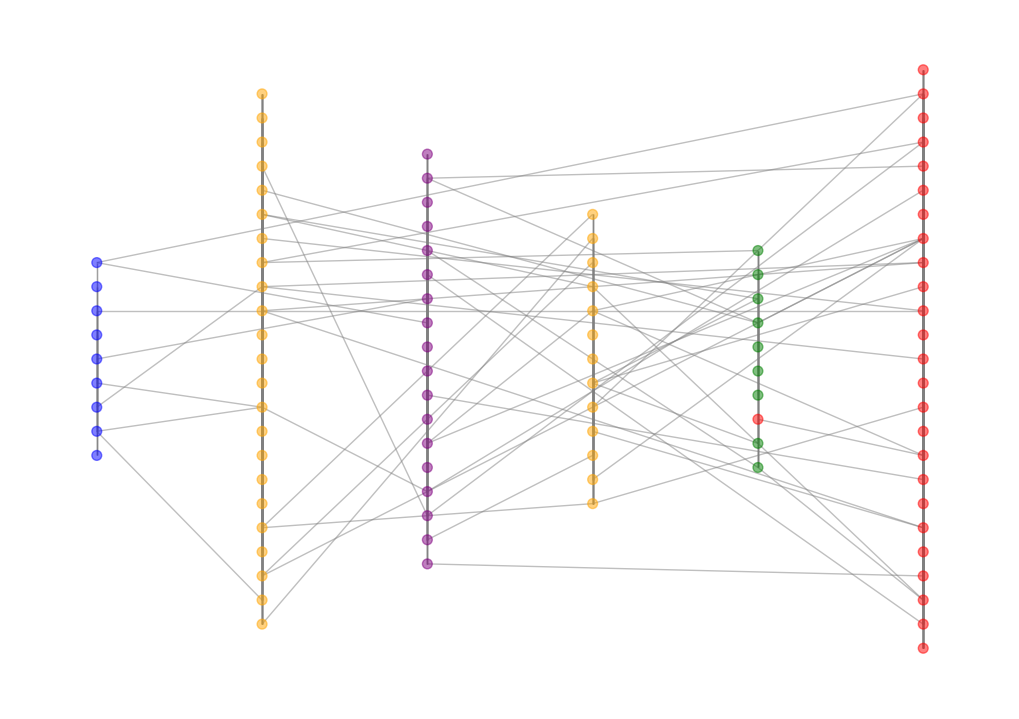

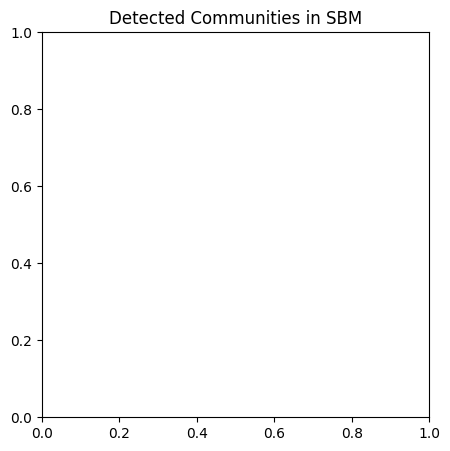

In [15]:
"""
print("Number of communities detected:", len(set(greedy_partition.values())))
print("Communities detected:")
for node, module in sorted(greedy_partition.items()):
    print(f"Node {node} -> Community {module}")
"""
#best_score = compute_map_equation(G, transition_matrix, greedy_partition)

plot_communities_sbm(G, fin_partition)

## Simulated Annealing

In [26]:
final_partition = simulated_annealing_infomap(G, transition_matrix, visit_probs, fin_partition, num_iterations=100)

In [27]:
#final_score = compute_map_equation(G, transition_matrix, final_partition)

print("Number of communities detected:", len(set(final_partition.values())))
#print("Greedy partition map equation:", best_score)
#print("Final partition map equation:", final_score)

# Plot the detected communities
plot_communities_sbm(G, final_partition)

Number of communities detected: 496


IndexError: list index out of range

<Figure size 1000x700 with 0 Axes>

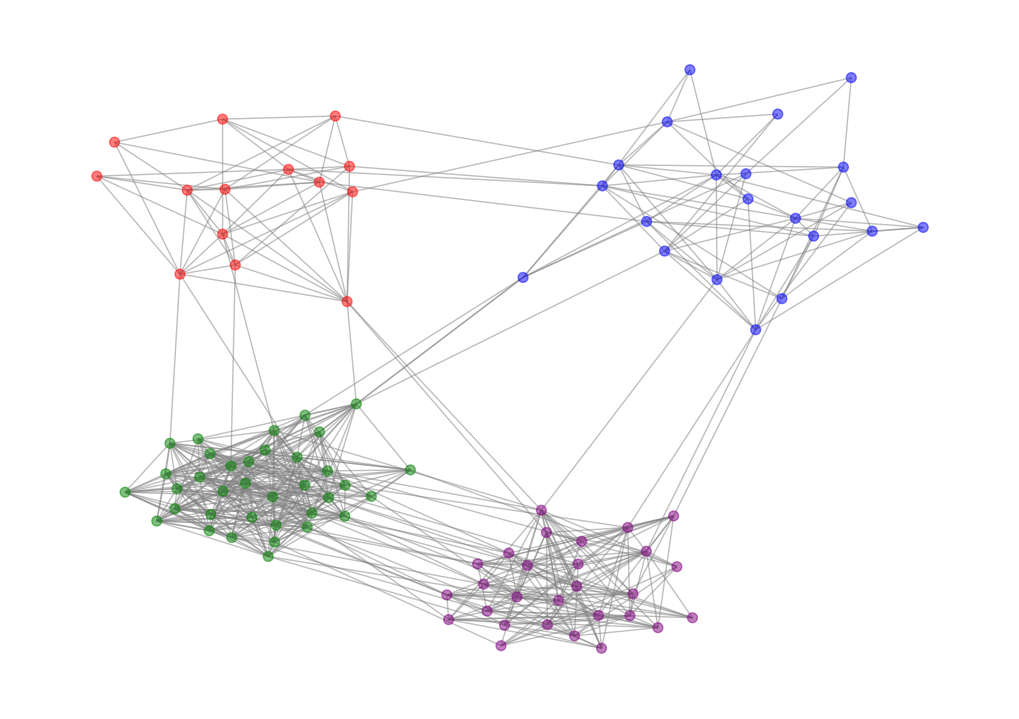

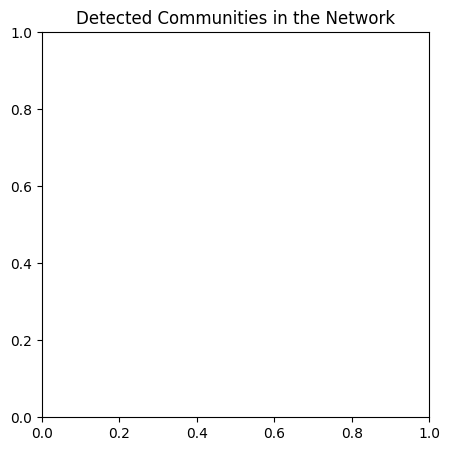

In [55]:
plot_communities(G, final_partition)


In [ ]:
"""

A = sparse((Nauthors,Npapers))

for i in authors:
    for k in authored_papers:
        A[i,k]=1


Adj = sparse((Nauthors,Nauthors))


for k in papers:
    papers_authors=np.where(A[:,i])

    for i in papers_authors:
        for j in papers_authors:
               Adj[i,j]+=1 

"""
